<hr style="height:2px;">

# Demo: Probabilistic neural network training for denoising of synthetic 2D data

This notebook demonstrates training a probabilistic CARE model for a 2D denoising task, using provided synthetic training data.  
Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [ ]:
# limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Download and read provided training data, use 10% as validation data.

In [3]:
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/synthetic_disks.zip',
    targetdir = 'data',
)

Files found, nothing to download.

data:
- synthetic_disks
- synthetic_disks/data.npz


In [4]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/synthetic_disks/data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 180
number of validation images:	 20
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


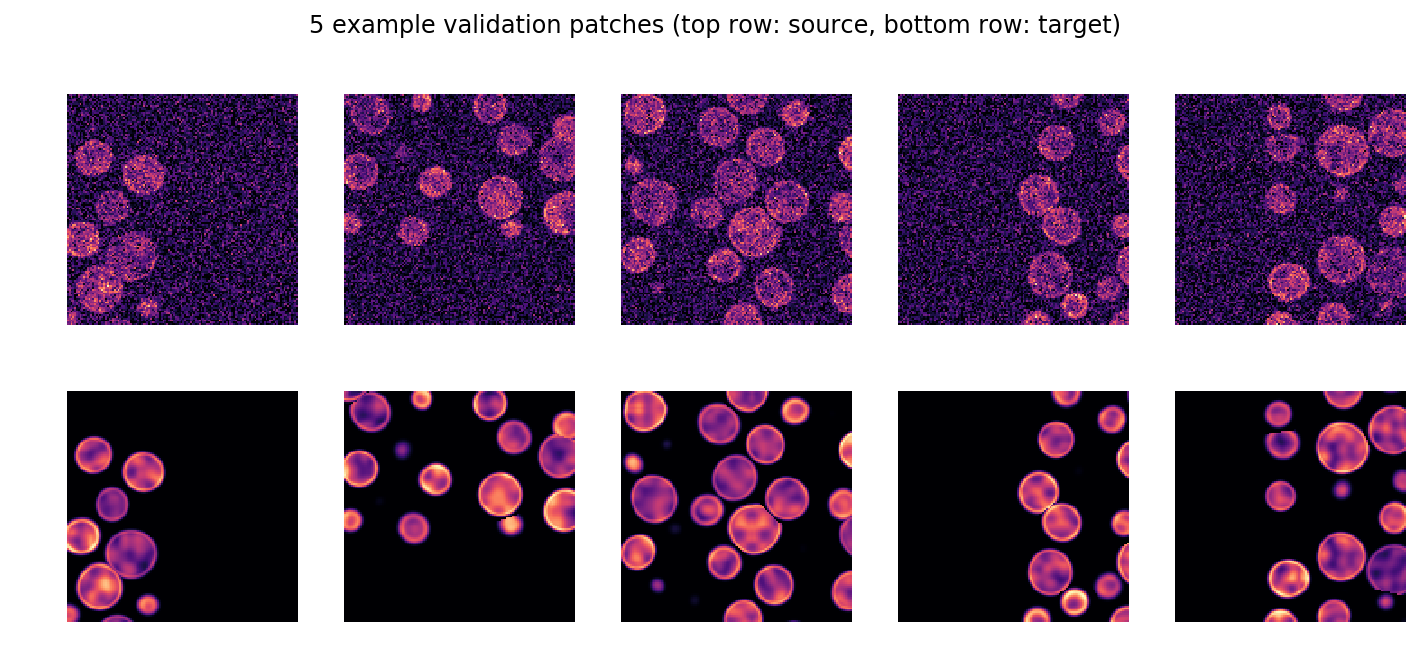

In [5]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

For a probabilistic model, we have to explicitly set `probabilistic=True`.

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [6]:
config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': True,
 'train_batch_size': 16,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 100,
 'train_learning_rate': 0.0004,
 'train_loss': 'laplace',
 'train_reduce_lr': {'factor': 0.5, 'min_delta': 0, 'patience': 10},
 'train_steps_per_epoch': 30,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 5,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': True}

We now create a CARE model with the chosen configuration:

In [7]:
model = CARE(config, 'my_model', basedir='models')

/usr/local/lib/python3.5/dist-packages/csbdeep/models/care_standard.py:139: UserWarning: output path for model already exists, files may be overwritten: /tf/Documents/CARE/CSBDeep-master/examples/denoising2D_probabilistic/models/my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) (example below), which allows you to inspect the losses during training.
Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.`
Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

![](http://csbdeep.bioimagecomputing.com/img/tensorboard_denoising2D_probabilistic.png)

In [9]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
30/30 [==============================] - 4s 147ms/step - loss: 0.3423 - mse: 0.0364 - mae: 0.1476 - val_loss: -0.0175 - val_mse: 0.0276 - val_mae: 0.1272
Epoch 2/100
30/30 [==============================] - 2s 53ms/step - loss: -0.2714 - mse: 0.0245 - mae: 0.1219 - val_loss: -0.2959 - val_mse: 0.0230 - val_mae: 0.1178
Epoch 3/100
30/30 [==============================] - 2s 56ms/step - loss: -0.5270 - mse: 0.0177 - mae: 0.1038 - val_loss: -0.7144 - val_mse: 0.0129 - val_mae: 0.0887
Epoch 4/100
30/30 [==============================] - 2s 53ms/step - loss: -0.8501 - mse: 0.0109 - mae: 0.0788 - val_loss: -0.9368 - val_mse: 0.0091 - val_mae: 0.0721
Epoch 5/100
30/30 [==============================] - 2s 55ms/step - loss: -0.8980 - mse: 0.0097 - mae: 0.0732 - val_loss: -0.6983 - val_mse: 0.0091 - val_mae: 0.0756
Epoch 6/100
30/30 [==============================] - 2s 56ms/step - loss: -0.9994 - mse: 0.0087 - mae: 0.0658 - val_loss: -1.2376 - val_mse: 0.0065 - val_mae: 0.0547
Epoc

Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


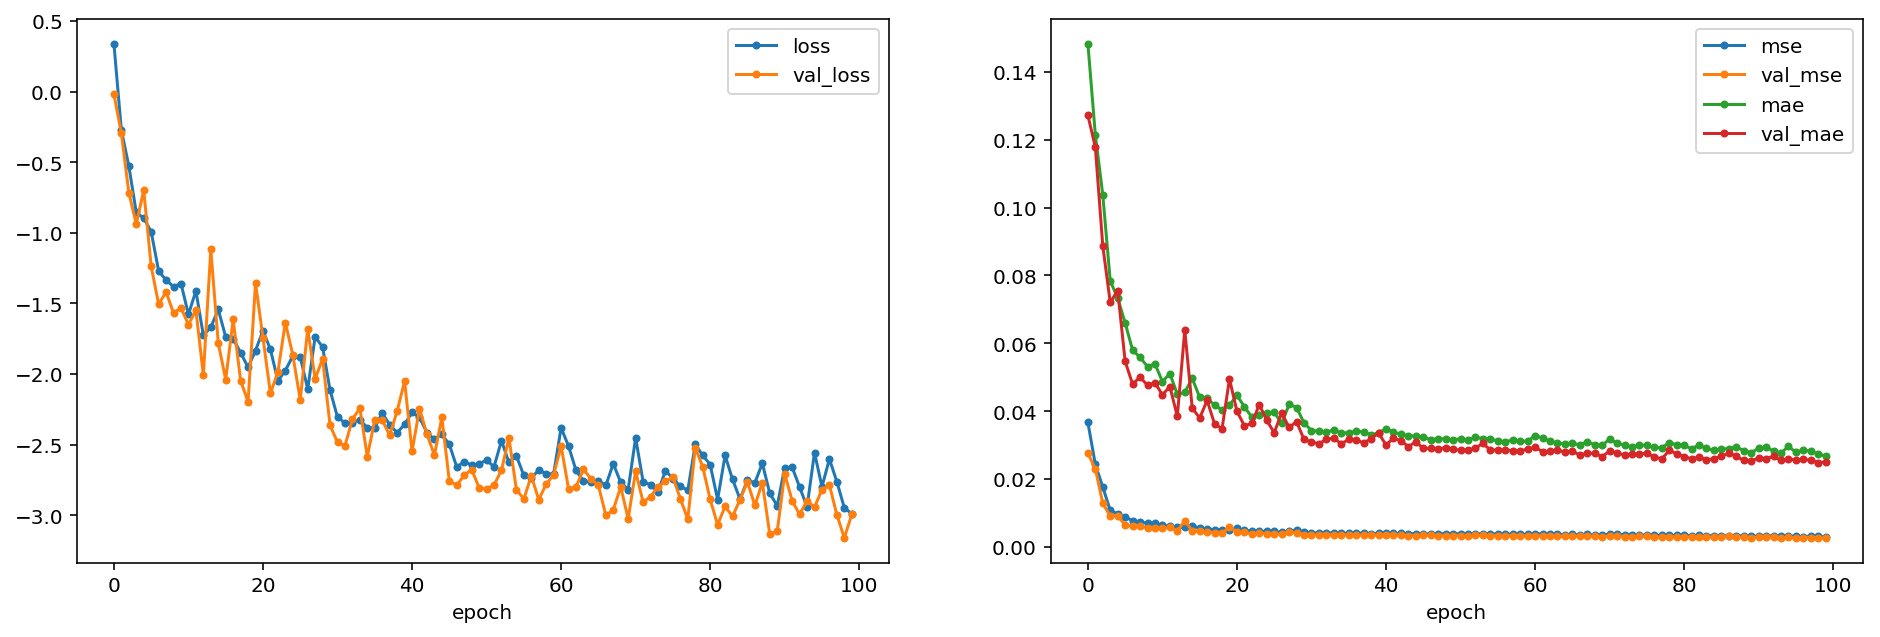

In [10]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

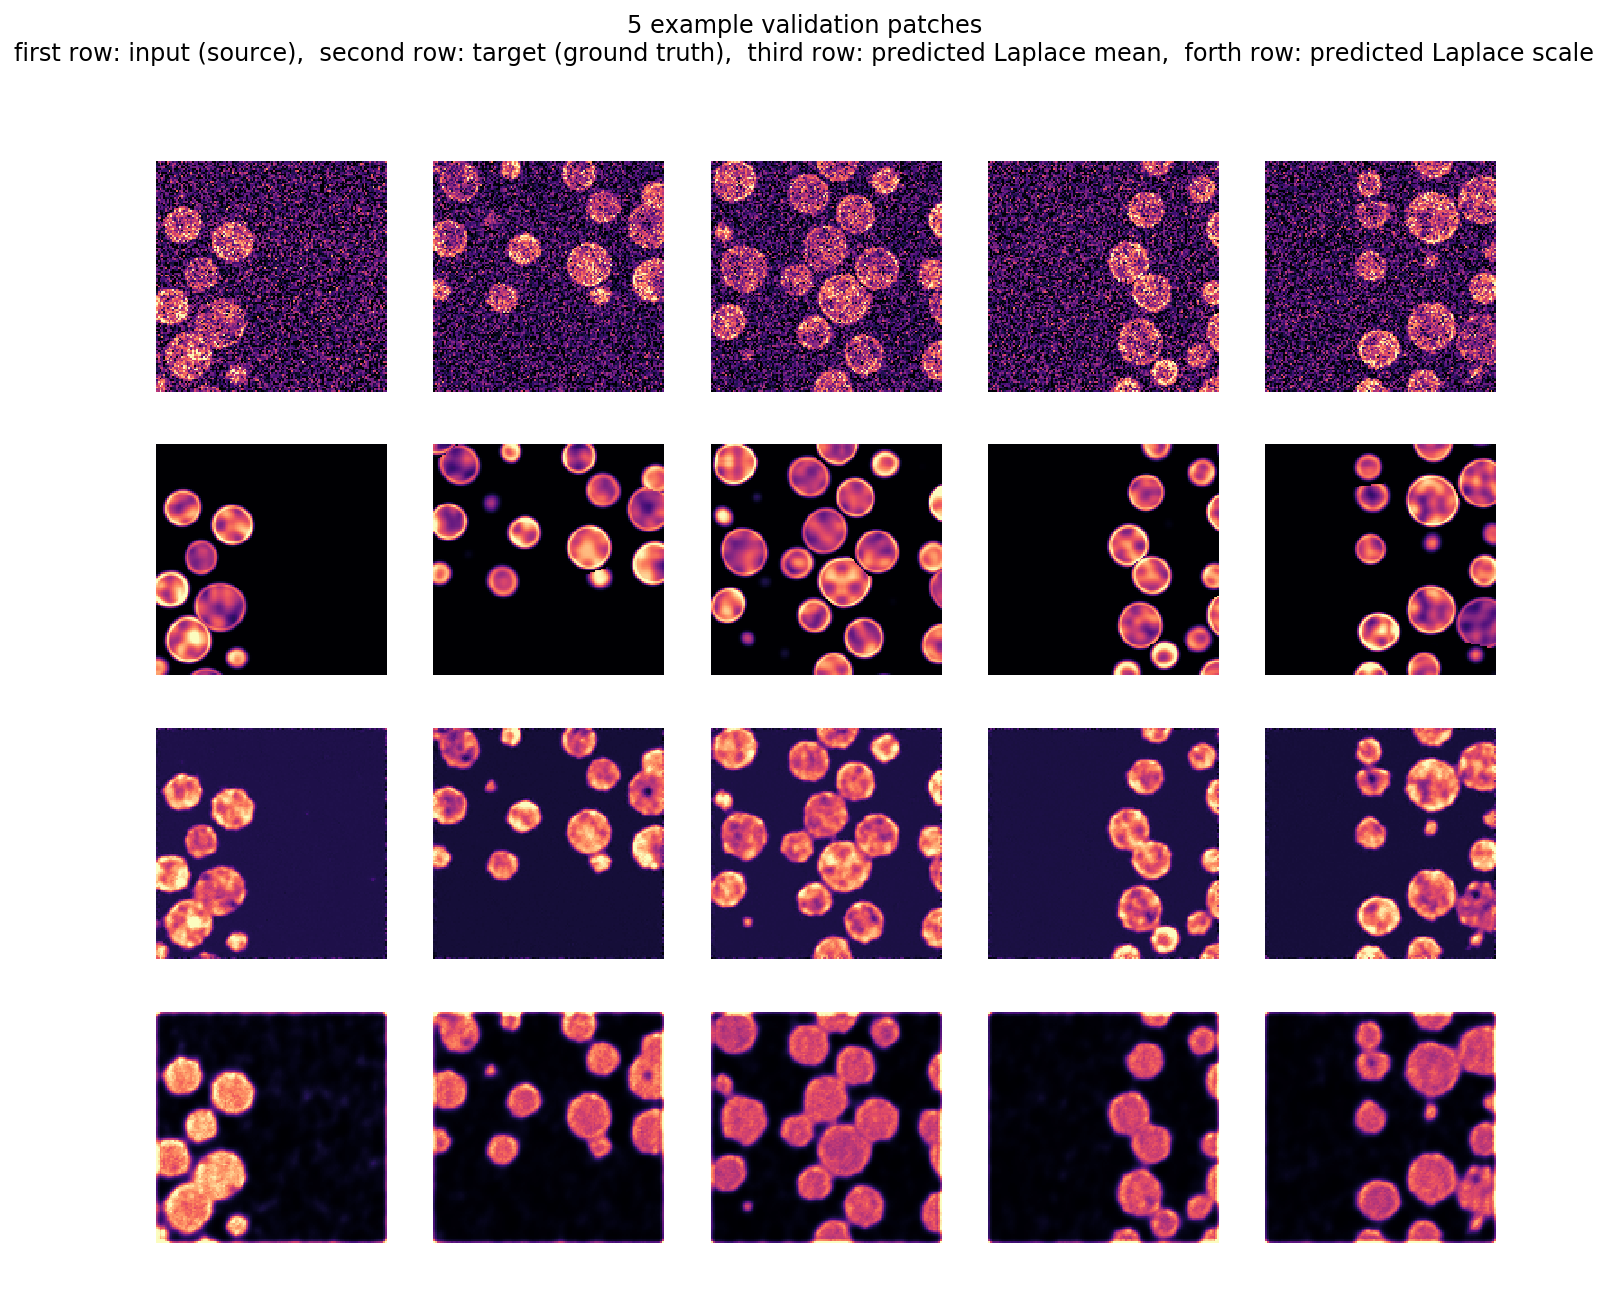

In [9]:
plt.figure(figsize=(12,10))
_P = model.keras_model.predict(X_val[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_val[:5],Y_val[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()

# <font color="red"> Please remember to restart or stop the notebook once you are done. Thank you. </font>